### Parameter-efficient fine-tuning with LoRA

<i>Low-rank adaptation (LoRA)</i> is one of the most widely used techniques for parameter-efficient fine-tuning. LoRA is a technique that adapts a pretrained model to better suit a specific, often smaller dataset by adjusting only a small subset of the model's weight parameters. The "low-rank" aspect refers to the mathematical concept of limiting model adjustments to a smaller dimensional subspace of the total weight parameter space. This effectively captures the most influential directions of the weight parameter changes during training. LoRA is useful and popular because it enables efficient fine-tuning of large models on task-specific data, significantly cutting down on computational costs and resources usually required for fine-tuning. 

Suppose a large weight matrix W is associated with a specific layer (LoRA can be applied to all linear layers in an LLM but we focus on a single layer for illustration purposes). During backpropagation, we learn a ΔW matrix, which contains information on how much we want to update the original weight parameters to minimise the loss function during training (from now on "weight" = model's weight parameters). In regular training and fine-tuning, the weight update is defined as<br>

W<sub>updated</sub> = W + WΔ

The LoRA method offers a more efficient alternative to computing the weight updates by learning an approximation of it:

ΔW ≈ AB

where A and B are two matrices much smaller than W, and AB represents the matrix multiplication product between A and B. Using LoRA, we can reformulate the weight update defined earlier:

W<sub>updated</sub> = W + AB

#### Preparing the dataset

In [1]:
import pandas as pd
train_df = pd.read_parquet("../Datasets/train.parquet")
valid_df = pd.read_parquet("../Datasets/valid.parquet")
test_df = pd.read_parquet("../Datasets/test.parquet")

In [2]:
import torch
from torch.utils.data import Dataset
from Chapter05 import tokeniser
from Chapter06 import SpamDataset

train_dataset = SpamDataset("../Datasets/train.parquet", 
                            max_length=None,
                            tokeniser=tokeniser
)
val_dataset = SpamDataset("../Datasets/valid.parquet", 
                            max_length=None,
                            tokeniser=tokeniser
)
test_dataset = SpamDataset("../Datasets/test.parquet", 
                            max_length=None,
                            tokeniser=tokeniser
)

In [3]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(42)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [4]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Target batch dimensions:", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 109])
Target batch dimensions: torch.Size([8])


In [5]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


#### Initialising the model

In [6]:

from Chapter05 import model_configs, load_weights_into_gpt
from Chapter04 import GPTModel
from gpt_download import download_and_load_gpt2

CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50_257,
    "context_length": 1_024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [7]:
# Double-check coherent text is generated. Clearly not.
from Chapter04 import generate_text_simple
from Chapter05 import text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokeniser),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokeniser))

Every effort moves you to the point of the "I-don-it-from-the


In [8]:
# Replace output layer for classification fine-tuning
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [9]:
# Classification accuracy of not-fine-tuned model
from Chapter06 import calc_accuracy_loader

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
        train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

In [10]:
# No better than random guessing
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 53.75%
Test accuracy: 58.75%


#### Parameter-efficient fine-tuning with LoRA

We initialise a LoRA-Layer that creates the matrices A and B, along with the 'alpha' scaling factor and the 'rank' (r) setting. 

In [9]:
import math

class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

The rank governs the inner dimension of matrices A and B. Essentially this determines the number of extra parameters introduced by LoRA, which creates balance between the adaptability of the model and its efficiency via the number of parameters used.

Alpha is a scaling factor for the output from the low-rank adaptation. It primarily dictates the degree to which the output from the adapted layer can affect the original layer's output. This can be seen as a way to regulate the effect of the low-rank adaptation on the layer's output. 

In LoRA, the typical goal is to substitute existing Linear layers, allowing weight updates to be applied directly to the pre-existing pretrained weights. To integrate the original Linear layers, we create a LinearWithLoRA layer, which utilises the previously implemented LoRALayer and is designed to replace the existing Linear layers within a neural network, such as the self-attention modules or feed-forward modules in GPTModel.

In [10]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

The code above combines a standard Linear layer with the LoRA layer. The forward method computes the output by adding the results from the original linear layer and the LoRA layer. 

Since the weight matrix B (self.B in LoRALayer) is initialised with zero values, the product of matrices A and B will be a zero matrix. This ensures that the multiplication does not alter the original weights, as adding zero does not change them. 

To apply LoRA, we introduce a replace_linear_lora_function, which will swap all existing Linear layers in GPTModel with the newly created LinearWithLoRA layers.

In [11]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            replace_linear_with_lora(module, rank, alpha)

In [12]:
# Freeze original model parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters after: {total_params:,}")

Total number of trainable parameters before: 124,441,346
Total number of trainable parameters after: 0


In [13]:
replace_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable LoRA parameters: {total_params:,}")

Total number of trainable LoRA parameters: 2,666,528


We reduced the number of trainable parameters by 50x when using LoRA. A rank and alpha of 16 are good default choices, but it is also common to increase the rank parameter, which in turn increases the number of trainable parameters. Alpha is usually chosen to be half, double, or equal to the rank.

In [14]:
# Verify layers have been modified as intended
model.to(device)
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

In [17]:
# Calculate initial classification accuracy before fine-tuning
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
        train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 53.75%
Test accuracy: 58.75%


The results are identical to the previous values - we initialised the LoRA matrix with zeros. Now we will fine-tune the model.

In [15]:
import time
from Chapter06 import train_classifier_simple

start_time = time.time()
torch.manual_seed(123)
optimiser = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimiser, device,
        num_epochs=num_epochs, eval_freq=50, eval_iter=5
    )

end_time = time.time()
execution_time_mins = (end_time - start_time) / 60
print(f"Training completed in {execution_time_mins:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 0.809, Val loss 0.909
Epoch 1 (Step 000050): Train loss 0.078, Val loss 0.257
Epoch 1 (Step 000100): Train loss 0.454, Val loss 0.300
Training accuracy: 95.00% | Validation accuracy: 90.00%
Epoch 2 (Step 000150): Train loss 0.400, Val loss 0.387
Epoch 2 (Step 000200): Train loss 0.528, Val loss 0.526
Epoch 2 (Step 000250): Train loss 0.022, Val loss 0.253
Training accuracy: 100.00% | Validation accuracy: 95.00%
Epoch 3 (Step 000300): Train loss 0.451, Val loss 0.313
Epoch 3 (Step 000350): Train loss 0.357, Val loss 0.537
Training accuracy: 100.00% | Validation accuracy: 82.50%
Epoch 4 (Step 000400): Train loss 0.126, Val loss 0.296
Epoch 4 (Step 000450): Train loss 0.009, Val loss 0.303
Epoch 4 (Step 000500): Train loss 0.108, Val loss 0.240
Training accuracy: 100.00% | Validation accuracy: 95.00%
Epoch 5 (Step 000550): Train loss 0.012, Val loss 0.149
Epoch 5 (Step 000600): Train loss 0.057, Val loss 0.190
Training accuracy: 97.50% | Validation accura

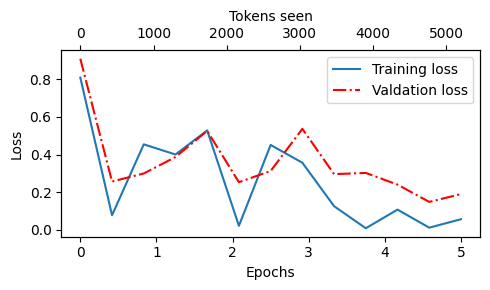

In [16]:
from Chapter05 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_losses(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Let's also calculate the accuracies on the full datasets (during training we approximated the training and validation set accuracies from 5 batches via the eval_iter=5 setting).

In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")